In [1]:
from fastai.vision.all import *

In [2]:
import fastai 
fastai.__version__

'2.3.1'

In [4]:
path= 'F:/Projet_computer_vision/plant-pathology-2021-fgvc8/compressed/'

In [5]:
df = pd.read_csv(path+'train_comp.csv')
df.head()

,image,labels
0,Compressed_800113bb65efe69e.jpg,healthy
1,Compressed_8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,Compressed_80070f7fb5e2ccaa.jpg,scab
3,Compressed_80077517781fb94f.jpg,scab
4,Compressed_800cbf0ff87721f8.jpg,complex


In [7]:
#splitter
splitter = RandomSplitter(valid_pct=0.33, seed=2021)


# DataBlock
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=ColReader('image', pref=str(path+'train_images/') ),
                   get_y=ColReader('labels', label_delim=' '), 
                   splitter=splitter,
                   item_tfms = Resize(460),
                   batch_tfms=aug_transforms(mult=2, size=224, flip_vert=True))

dls = dblock.dataloaders(df)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


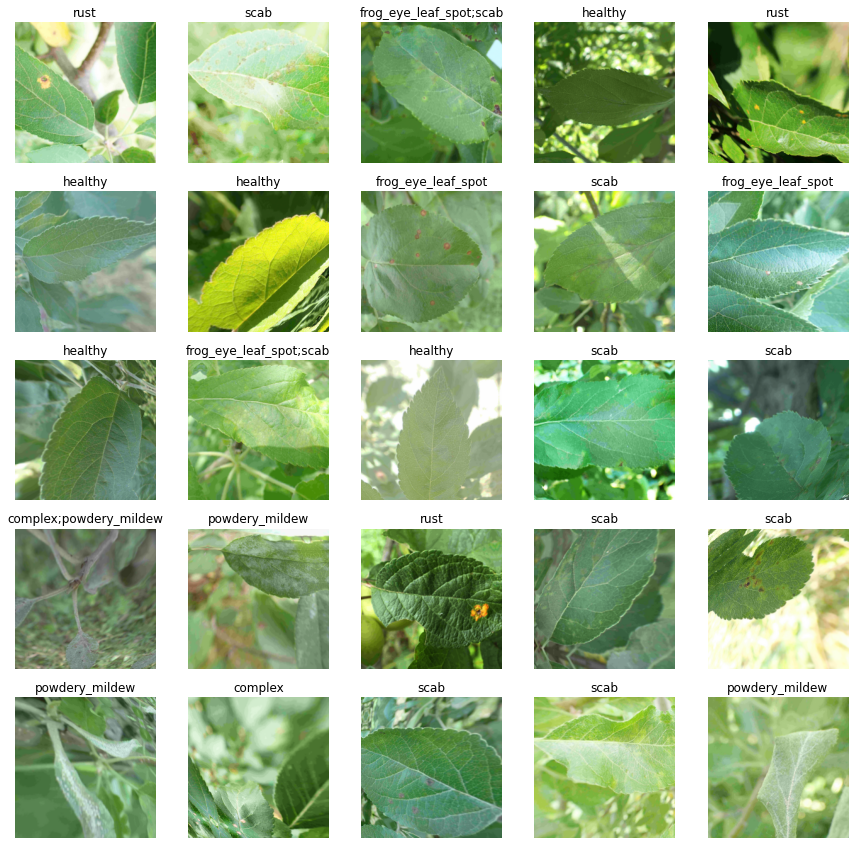

In [8]:
dls.show_batch(max_n=25)

In [42]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.5))

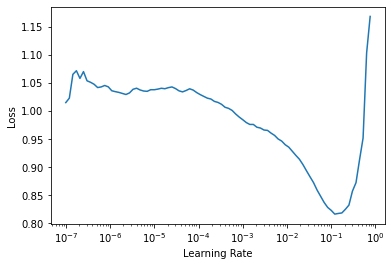

In [56]:
from time import time
debut= time()
lr,lr_steepest = learn.lr_find(suggestions=true)


In [57]:
duree2 = time()- debut
print("durée 2 : pour trouver le meilleur learning rate  (en secondes) =", duree2)
print("lr= ",lr," lr_steepest= ",lr_steepest)

durée 2 : pour trouver le meilleur learning rate  (en secondes) = 2080.3082695007324
lr=  0.012022644281387329  lr_steepest=  0.03981071710586548


In [58]:
# j'ai choisi le steepest point (la pente la plus raide ou le point d'inflexion) : le point où la fonction loss diminue 
# le plus rapidement par step,  cad le réseau apprend aussi vite que possible.
learn.fine_tune(2, 4e-2)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.247588,0.151002,0.941309,1:30:46


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.194189,0.165463,0.933230,1:38:50
1,0.142034,0.106387,0.957574,1:37:25


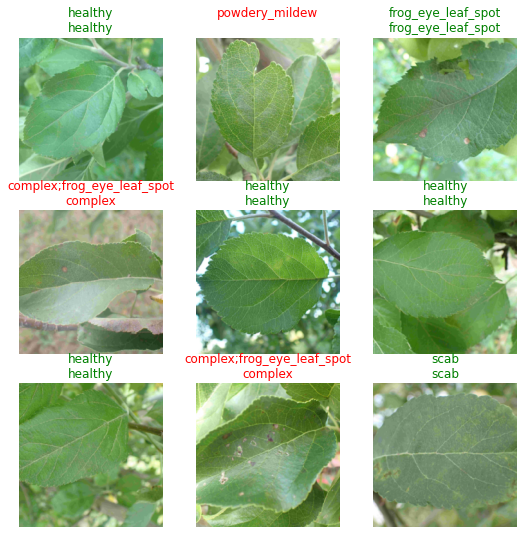

In [59]:
learn.show_results()

In [19]:
learn.dls.vocab

['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']

In [16]:
# prévision pour la 1ère image du testing set
learn.predict(path+'test_images/85f8cb619c66b863.jpg')

((#1) ['scab'],
 tensor([False, False, False, False, False,  True]),
 tensor([1.7340e-02, 1.2932e-02, 8.4768e-05, 1.7768e-04, 6.7964e-04, 9.8608e-01]))

In [29]:
# prévision pour la 2ème image du testing set
learn.predict(path+'test_images/ad8770db05586b59.jpg')

((#2) ['complex','scab'],
 tensor([ True, False, False, False, False,  True]),
 tensor([7.4899e-01, 3.9676e-01, 2.7095e-05, 1.0192e-04, 2.2685e-03, 5.5899e-01]))

In [30]:
# prévision pour la 3ème image du testing set
learn.predict(path+'test_images/c7b03e718489f3ca.jpg')

((#1) ['frog_eye_leaf_spot'],
 tensor([False,  True, False, False, False, False]),
 tensor([1.9244e-02, 9.7536e-01, 5.0063e-04, 2.7376e-05, 1.8823e-03, 1.1797e-02]))

In [23]:
# prévision pour les 3 images à la fois  du testing set
test_dl = dls.test_dl(get_image_files(path+'test_images')
                          .sorted())
                         

preds= learn.get_preds(dl=test_dl)

In [24]:
preds[0].numpy()

array([[1.7339829e-02, 1.2932221e-02, 8.4767868e-05, 1.7768177e-04,
        6.7964144e-04, 9.8607987e-01],
       [7.4899036e-01, 3.9675647e-01, 2.7095231e-05, 1.0192478e-04,
        2.2685025e-03, 5.5898875e-01],
       [1.9244125e-02, 9.7536308e-01, 5.0063024e-04, 2.7376365e-05,
        1.8822738e-03, 1.1796816e-02]], dtype=float32)

In [26]:
preds_round= preds[0].round()
preds_round

tensor([[0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0.]])

In [27]:
df_test=pd.DataFrame(preds_round, columns=['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab'])
df_test

,complex,frog_eye_leaf_spot,healthy,powdery_mildew,rust,scab
0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0


In [33]:
SUB_PATH = "F:/Projet_computer_vision/plant-pathology-2021-fgvc8/sample_submission.csv"
test_data = pd.read_csv(SUB_PATH)
test_data

,image,labels
0,85f8cb619c66b863.jpg,healthy
1,ad8770db05586b59.jpg,healthy
2,c7b03e718489f3ca.jpg,healthy


In [34]:
# prévision pour les 3 images à la fois  du testing set

df_test['labels'] = df_test['healthy'].apply(lambda x:'healthy ' if x==1 else "") \
                        + df_test['scab'].apply(lambda x:'scab ' if x==1 else "") \
                        +  df_test['rust'].apply(lambda x:'rust ' if x==1 else "")  \
                        +   df_test['powdery_mildew'].apply(lambda x:'powdery_mildew ' if x==1 else "")  \
                        + df_test['frog_eye_leaf_spot'].apply(lambda x:'frog_eye_leaf_spot ' if x==1 else "") \
                        + df_test['complex'].apply(lambda x:'complex ' if x==1 else "") 
                                                                                
df_test['labels']= df_test['labels'].str.strip()
df_test['labels'] = df_test['labels'].apply(lambda x:'healthy' if x=="" else x)
test_data['labels']= df_test['labels']
print(test_data)

                  image              labels
0  85f8cb619c66b863.jpg                scab
1  ad8770db05586b59.jpg        scab complex
2  c7b03e718489f3ca.jpg  frog_eye_leaf_spot


In [35]:
# submitting to kaggle competition
test_data.to_csv('submission.csv',index=False)

,target,predicted,probabilities,loss
0,complex,scab,"tensor([5.1503e-04, 1.0723e-03, 2.4133e-07, 1.3769e-05, 6.8137e-05, 9.9944e-01])",2.511030912399292
1,complex,rust,"tensor([4.4275e-03, 4.1336e-03, 2.9621e-08, 2.7349e-07, 9.9947e-01, 3.9278e-05])",2.161099672317505
2,scab,healthy,"tensor([7.0919e-04, 7.1364e-04, 9.9669e-01, 3.5740e-04, 5.7901e-04, 1.8656e-03])",1.9997906684875488
3,scab,healthy,"tensor([2.3314e-04, 6.2732e-04, 9.9655e-01, 4.1049e-05, 1.6876e-04, 2.4200e-03])",1.9491556882858276
4,complex;rust,frog_eye_leaf_spot,"tensor([0.0351, 0.8922, 0.0605, 0.0088, 0.0028, 0.0397])",1.9261060953140259
5,healthy,powdery_mildew,"tensor([1.6445e-02, 4.6744e-04, 4.5009e-03, 9.9699e-01, 2.2968e-05, 2.4080e-03])",1.8712478876113892
6,complex;frog_eye_leaf_spot;scab,scab,"tensor([4.7659e-03, 6.0799e-03, 4.1277e-04, 6.8064e-04, 3.2964e-04, 9.9112e-01])",1.7432297468185425
7,scab,healthy,"tensor([6.7250e-03, 8.0067e-04, 9.8912e-01, 1.6993e-04, 3.9282e-03, 2.7002e-03])",1.7411435842514038
8,complex,frog_eye_leaf_spot,"tensor([4.6309e-03, 9.9348e-01, 9.7431e-04, 2.5182e-05, 2.1675e-04, 6.8596e-03])",1.7361211776733398


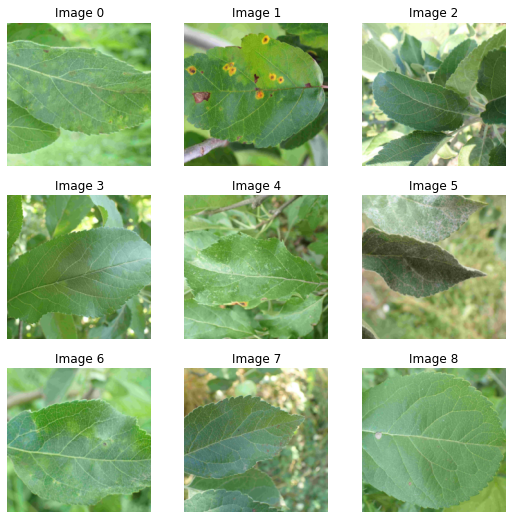

In [36]:
# les 9 plus mauvaises prédictions 
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9)

,target,predicted,probabilities,loss
0,complex,scab,"tensor([5.1503e-04, 1.0723e-03, 2.4133e-07, 1.3769e-05, 6.8137e-05, 9.9944e-01])",2.511030912399292
1,complex,rust,"tensor([4.4275e-03, 4.1336e-03, 2.9621e-08, 2.7349e-07, 9.9947e-01, 3.9278e-05])",2.161099672317505


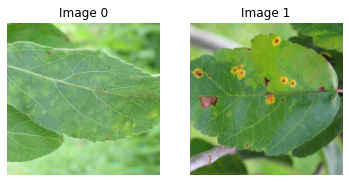

In [37]:
# les 2  plus mauvaises prédictions 
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(2)